In [1]:
import os, sys
# add to path
sys.path.append("../..")

import attr
import datetime

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import seaborn

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_probability as tfp
tfd = tfp.distributions

seaborn.set()

In [2]:
tf.config.set_visible_devices([], 'GPU') 

In [3]:
# %load_ext tensorboard
log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [4]:
from filterflow.smc import SMC
from filterflow.base import State, StateSeries, DTYPE_TO_OBSERVATION_SERIES

from filterflow.observation.linear import LinearObservationSampler

from filterflow.transition.random_walk import RandomWalkModel
from filterflow.proposal import BootstrapProposalModel
from filterflow.proposal.auxiliary_proposal import AuxiliaryProposal

from filterflow.resampling.criterion import NeffCriterion, AlwaysResample, NeverResample
from filterflow.resampling.standard import SystematicResampler, MultinomialResampler
from filterflow.resampling.differentiable import RegularisedTransform, CorrectedRegularizedTransform
from filterflow.resampling.differentiable.ricatti.solver import PetkovSolver, NaiveSolver

from filterflow.resampling.base import NoResampling

from filterflow.state_space_model import StateSpaceModel

## Set the State Space Model

In [5]:
tf.random.set_seed(0)
observation_dim = 2
state_dim = 2
T = 150
initial_state          = tf.random.uniform([state_dim], -1., 1.)

transition_matrix      = tf.eye(state_dim) * 0.5
transition_covariance  = tf.eye(state_dim) * 0.5

chol_transition_covariance = tf.linalg.cholesky(transition_covariance)

observation_matrix     = tf.eye(observation_dim) * 0.5
observation_covariance = tf.eye(observation_dim) * 0.1

chol_observation_covariance = tf.linalg.cholesky(observation_covariance)

In [6]:
# Transition
zeros = tf.zeros(state_dim, dtype=float)

transition_noise = tfd.MultivariateNormalTriL(zeros, chol_transition_covariance)
transition_model = RandomWalkModel(transition_matrix, transition_noise)

# Observation
observation_error = tfp.distributions.MultivariateNormalTriL(zeros, chol_observation_covariance)
observation_model = LinearObservationSampler(observation_matrix, observation_error)

In [7]:
## State space model
ss_model = StateSpaceModel(observation_model=observation_model, transition_model=transition_model)
states, observations = ss_model(initial_state, T)

In [8]:
np_obs = np.array([observations[t].numpy().squeeze() for t in range(T)])
np_states = np.array([states[t].particles.numpy().squeeze() for t in range(T)])

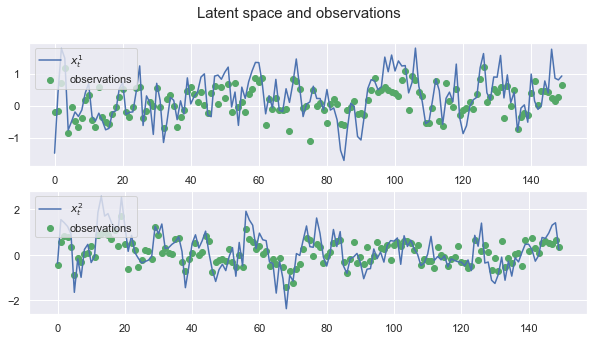

In [9]:
linspace  = np.arange(np_obs[:,0].shape[0])
fig, axes = plt.subplots(nrows=2, figsize=(10, 5))
axes[0].scatter(linspace, np_obs[:,0], marker='o', color='g', label='observations')
axes[0].plot(np_states[:, 0], color='b', label='$x^1_t$')
axes[1].plot(np_states[:, 1], color='b', label='$x^2_t$')
axes[1].scatter(linspace, np_obs[:,1], marker='o', color='g', label='observations')
_ = axes[0].legend(loc='upper left')
_ = axes[1].legend(loc='upper left')
_ = fig.suptitle('Latent space and observations', fontsize=15)

In [10]:
obs_data = tf.data.Dataset.from_tensor_slices(observations)

### Set up the filter

In [11]:
# store observations
batch_size = 10
n_particles = 25
dimension = 2

initial_weights = tf.ones((batch_size, n_particles), dtype=float) / tf.cast(n_particles, float)
initial_particles = tf.random.uniform((batch_size, n_particles, dimension), -1, 1)
log_likelihoods = tf.zeros(batch_size, dtype=float)
initial_state = State(particles=initial_particles, 
                      log_weights = tf.math.log(initial_weights),
                      weights=initial_weights, 
                      log_likelihoods=log_likelihoods, 
                      ancestor_indices = None, 
                      resampling_correction = None)


In [12]:
init_transition_matrix = 0. * tf.eye(state_dim)
learnable_transition_matrix = tf.Variable(init_transition_matrix, trainable=True)

init_triangular_covariance = tf.eye(state_dim)
learnable_transition_covariance = tf.Variable(init_triangular_covariance, trainable=True)

In [13]:
resampling_criterion = NeffCriterion(tf.constant(0.5), tf.constant(True))
systematic = SystematicResampler()

epsilon = tf.constant(0.5)
scaling = tf.constant(0.9)

regularized = RegularisedTransform(epsilon, scaling=scaling, max_iter=1000, convergence_threshold=1e-4)

solver = PetkovSolver(tf.constant(30))
corrected = CorrectedRegularizedTransform(epsilon, scaling=scaling, max_iter=1000, convergence_threshold=1e-4, ricatti_solver=solver, propagate_correction_gradient=False)

naive_solver = NaiveSolver(0.15, 10., 2e-2)
naive_corrected = CorrectedRegularizedTransform(epsilon, scaling=scaling, max_iter=1000, convergence_threshold=1e-4, ricatti_solver=naive_solver, propagate_correction_gradient=False)

zeros = tf.zeros(state_dim, dtype=float)
learnable_transition_noise = tfd.MultivariateNormalTriL(loc=zeros, scale_tril=learnable_transition_covariance)
learnable_transition_model = RandomWalkModel(learnable_transition_matrix, learnable_transition_noise)

proposal_model = BootstrapProposalModel(learnable_transition_model)
    
learnable_systematic_smc = SMC(observation_model, learnable_transition_model, proposal_model, resampling_criterion, systematic, correct_gradient=True)
learnable_regularized_smc = SMC(observation_model, learnable_transition_model, proposal_model, resampling_criterion, regularized)
learnable_corrected_smc = SMC(observation_model, learnable_transition_model, proposal_model, resampling_criterion, corrected)
learnable_naive_corrected_smc = SMC(observation_model, learnable_transition_model, proposal_model, resampling_criterion, naive_corrected)
true_smc = SMC(observation_model, transition_model, proposal_model, resampling_criterion, systematic)

In [14]:
@tf.function
def loss_func(smc, use_correction_term):
    final_state = smc(initial_state, observation_series=obs_data, n_observations=T, return_final=True)
    if use_correction_term:
        return -tf.reduce_mean(final_state.log_likelihoods), -tf.reduce_mean(final_state.resampling_correction)
    return -tf.reduce_mean(final_state.log_likelihoods), tf.constant(0.)

In [15]:
def train_one_step(optimizer, smc, use_correction_term):
    var_list= [learnable_transition_matrix, learnable_transition_covariance]
    with tf.GradientTape() as tape:
        tape.watch(var_list)
        real_loss, correction = loss_func(smc, use_correction_term)
        loss = real_loss + correction
    grads_loss = tape.gradient(loss, var_list)
    optimizer.apply_gradients(zip(grads_loss, var_list))
    return real_loss, grads_loss


def train(optimizer, smc, num_steps = 101, use_correction_term=False):
    assign_1 = learnable_transition_matrix.assign(init_transition_matrix)
    assign_2 = learnable_transition_covariance.assign(init_triangular_covariance)
    loss_tensor_array = tf.TensorArray(dtype=tf.float32, size=num_steps, dynamic_size=False, element_shape=[])
    grad_tensor_array = tf.TensorArray(dtype=tf.float32, size=num_steps, dynamic_size=False, element_shape=[])
    with tf.control_dependencies([assign_1, assign_2]):
        for step in tf.range(num_steps):
            loss, grads = train_one_step(optimizer, smc, use_correction_term)
            max_grad = tf.reduce_max(tf.abs(grads))
            tf.print('Step', step, '/', num_steps - 1, ': loss = ', loss, ', max abs grads = ', 
                     max_grad,
                     ', lr = ', optimizer.lr(step), end='\r')
            loss_tensor_array = loss_tensor_array.write(step, loss)
            grad_tensor_array = grad_tensor_array.write(step, max_grad)
    return loss_tensor_array.stack(), grad_tensor_array.stack(), tf.convert_to_tensor(learnable_transition_matrix), tf.convert_to_tensor(learnable_transition_covariance @ tf.transpose(learnable_transition_covariance))

In [16]:
num_steps = 101
lr_fn = tf.optimizers.schedules.PolynomialDecay(1e-1, num_steps, 1e-6, 1)

In [28]:
lr_fn = tf.optimizers.schedules.PolynomialDecay(1e-1, num_steps, 1e-6, 1)
optimizer = tf.optimizers.Adam(learning_rate=lr_fn)
corr_loss, corr_grad, corr_learned_transition_matrix, corr_learned_covariance = train(optimizer, learnable_corrected_smc, num_steps=num_steps)

In [17]:
lr_fn = tf.optimizers.schedules.PolynomialDecay(1e-1, num_steps, 1e-6, 1)
optimizer = tf.optimizers.Adam(learning_rate=lr_fn)
sys_loss, sys_grad, sys_learned_transition_matrix, sys_learned_covariance = train(optimizer, learnable_systematic_smc, num_steps=num_steps, use_correction_term=True)

In [18]:
lr_fn = tf.optimizers.schedules.PolynomialDecay(1e-1, num_steps, 1e-6, 1)
optimizer = tf.optimizers.Adam(learning_rate=lr_fn)
naive_loss, naive_grad, naive_learned_transition_matrix, naive_learned_covariance = train(optimizer, learnable_naive_corrected_smc, num_steps=num_steps)

In [19]:
lr_fn = tf.optimizers.schedules.PolynomialDecay(1e-1, num_steps, 1e-6, 1)
optimizer = tf.optimizers.Adam(learning_rate=lr_fn)
reg_loss, reg_grad, reg_learned_transition_matrix, reg_learned_covariance = train(optimizer, learnable_regularized_smc, num_steps=num_steps)

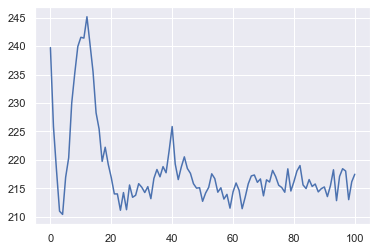

In [20]:
_ = plt.plot(sys_loss)

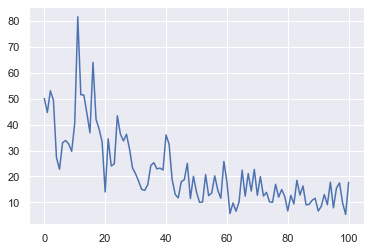

In [21]:
_ = plt.plot(sys_grad)

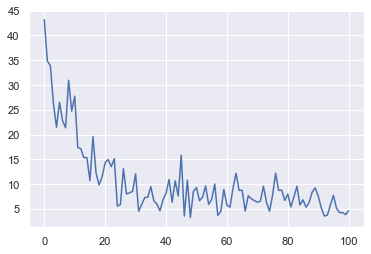

In [22]:
_ = plt.plot(reg_grad)

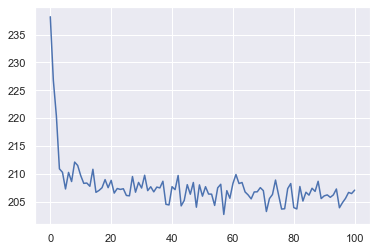

In [23]:
_ = plt.plot(reg_loss)

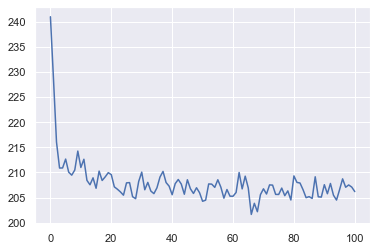

In [29]:
_ = plt.plot(corr_loss)

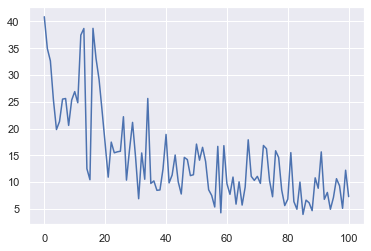

In [30]:
_ = plt.plot(corr_grad)

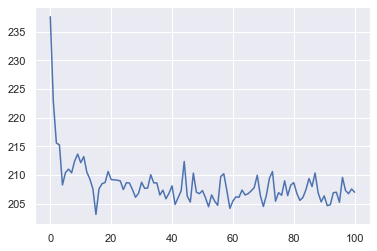

In [31]:
_ = plt.plot(naive_loss)

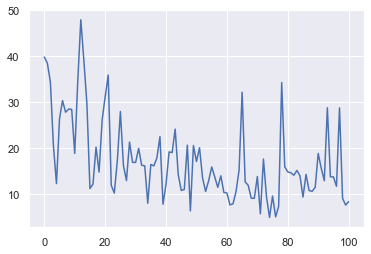

In [32]:
_ = plt.plot(naive_grad)

In [33]:
import pykalman
kf = pykalman.KalmanFilter(transition_matrix.numpy(), 
                           observation_matrix.numpy(), 
                           transition_covariance.numpy(), 
                           observation_covariance.numpy(), 
                           initial_state_mean=[0., 0.], 
                           initial_state_covariance= np.eye(2))

In [34]:
em_kf = kf.em(np_obs, n_iter = 100, em_vars=['transition_covariance', 'transition_matrices'])

In [35]:

print('\n Observation Matrix: ')
print(em_kf.observation_matrices)


print('\n Transition Matrix: ')
print(em_kf.transition_matrices)


print('\n Observation Covariance: ')
print(em_kf.observation_covariance)


print('\n Transition Covariance: ')
print(em_kf.transition_covariance)


 Observation Matrix: 
[[0.5 0. ]
 [0.  0.5]]

 Transition Matrix: 
[[0.42100968 0.11857956]
 [0.26292471 0.59502527]]

 Observation Covariance: 
[[0.1 0. ]
 [0.  0.1]]

 Transition Covariance: 
[[ 0.43603606 -0.07539243]
 [-0.07539243  0.4181404 ]]


In [36]:
sys_learned_covariance

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.23408766, 0.00711855],
       [0.00711855, 0.14144742]], dtype=float32)>

In [37]:
sys_learned_transition_matrix

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 0.5613318 , -0.02252263],
       [ 0.06032693,  0.7473055 ]], dtype=float32)>

In [38]:
reg_learned_covariance

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 0.42360362, -0.04444406],
       [-0.04444406,  0.44991228]], dtype=float32)>

In [39]:
reg_learned_transition_matrix

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.37842447, 0.09535584],
       [0.23322058, 0.6076486 ]], dtype=float32)>

In [40]:
corr_learned_covariance

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 0.4141796 , -0.05461121],
       [-0.05461121,  0.43367773]], dtype=float32)>

In [41]:
corr_learned_transition_matrix

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.38981944, 0.09833398],
       [0.24659988, 0.60698   ]], dtype=float32)>

In [42]:
naive_learned_covariance

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 0.4088326 , -0.05990361],
       [-0.05990361,  0.42814282]], dtype=float32)>

In [43]:
naive_learned_transition_matrix

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.39819804, 0.10015608],
       [0.20153493, 0.64471996]], dtype=float32)>